In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import uncertainties as unc

In [2]:
def transfer(F, R):
    # l = unc.ufloat(0.27058, 0.00046)
    # C = 0.5*l*29e-12*3.28084+ 12.5e-12
    l = unc.ufloat(0.27058, 0.001)
    C1 = l/0.3048*unc.ufloat(29e-12, 2.9e-12)
    CIn = unc.ufloat(25e-12,2.5e-12)
    C = (C1 + CIn)*(C1 + CIn)/(C1 + CIn + C1 + CIn) + unc.ufloat(2.5e-12, 0.1e-12)
    Rin = 2*unc.ufloat(10e6, 1e6)
    omega = 2*np.pi*F
    return 1/((R/Rin+1)**2+(omega*C*R)**2)**0.5


def transferCryo(F, R):
    l = unc.ufloat(0.27058, 0.1)
    C1 = l/0.3048*unc.ufloat(29e-12, 29*0.1e-12)
    C2 = unc.ufloat(36e-12, 3.6e-12)
    CIn = unc.ufloat(25e-12,2.5e-12)
    C = (C1 + CIn + C2)*(C1 + CIn +C2)/(C1 + CIn + C1 + CIn +C2 +C2) +unc.ufloat(18.3e-12, 0.1e-12)
    Rin = 2*unc.ufloat(10e6, 1e6)
    omega = 2*np.pi*F
    return 1/((R/Rin+1)**2+(omega*C*R)**2)**0.5

def curveFit(f, ThermalNoise, f1, alpha):
    return np.sqrt(ThermalNoise**2  +(f1*f**(-alpha))**2)

def excpectedThermal(F, R, T):
    return (4*1.380649e-23*T*R)**0.5
def thermalNoTransfer(R, T):
    return (4*1.380649e-23*T*R)**0.5
liquidN = thermalNoTransfer(1.09e6, 77)
print(liquidN)
l = unc.ufloat(0.27058, 0.1)
C1 = l*29e-12/0.3048
CIn = unc.ufloat(25e-12, 1e-12)
C = (C1 + CIn)*(C1 + CIn)/(C1 + CIn + C1 + CIn)
print(C)

6.808167758508893e-08
(2.5+/-0.5)e-11


In [3]:
def readData(fileName: str):
    data = pd.read_csv(fileName, sep="\t", header=None)
    return data[0], data[1]


0.06405111704962811 0.14300066995941668 0.20380011074927695


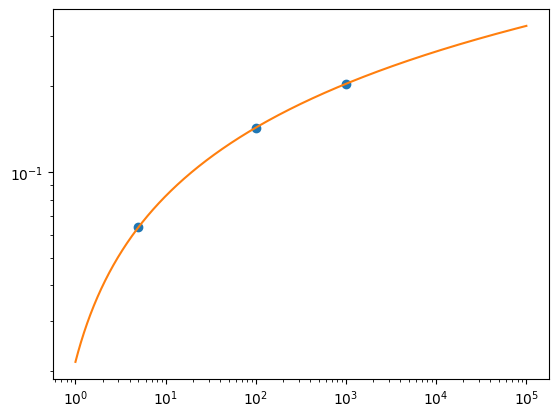

In [4]:
_, uncsV = readData("uncs.txt")
five = uncsV[0:20]
hundred = uncsV[20:40]
thousand = uncsV[40:60]
uncPctFive = np.std(five)/np.mean(five)
uncPctHundred = np.std(hundred)/np.mean(hundred)
uncPctThousand = np.std(thousand)/np.mean(thousand)
print(uncPctFive, uncPctHundred, uncPctThousand)
def uncFit(f, m, b):
    return m*np.log10(f)+b

uncpopt, pcov = curve_fit(uncFit, [5, 100, 1000], [uncPctFive, uncPctHundred, uncPctThousand] )
plt.plot([5, 100, 1000], [uncPctFive, uncPctHundred, uncPctThousand], 'o')
plt.plot(np.logspace(0, 5, num=1000), uncFit(np.logspace(0,5, num=1000), *uncpopt))
plt.xscale("log")
plt.yscale("log")
plt.show()
def voltageUncertainty(f):
    return uncFit(f, *uncpopt)

['data\\0Meg25GoodParam100msNoSync.txt', 'data\\0Meg5GoodParam100msNoSync.txt', 'data\\1MegGoodParam100msNoSync.txt', 'data\\cryoLowGood.txt', 'data\\cryoRoomGoodParam100msNoSync.txt']
[244648.0416156671+/-59.92608117886589, 500877.1055664111+/-25.10281605122557, 982361.2988799373+/-96.53284524267414, 984586.5829640572+/-96.97061378277276, 982650.9828009828+/-96.58977717945778]
<class 'pandas.core.series.Series'>
Expected thermal noise
(6.3239+/-0.0013)e-08
[5.67907893e-08 3.70441569e-04 3.45084504e+00]
Fit Thermal Noise 5.679078929134419e-08 +/- 1.949643261396963e-09
Reduced Chi2 0.8101501085891983


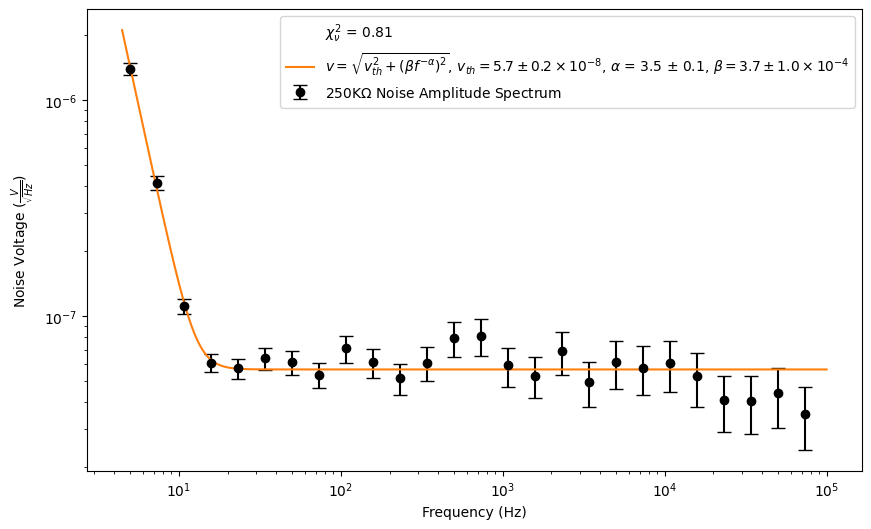

<Figure size 640x480 with 0 Axes>

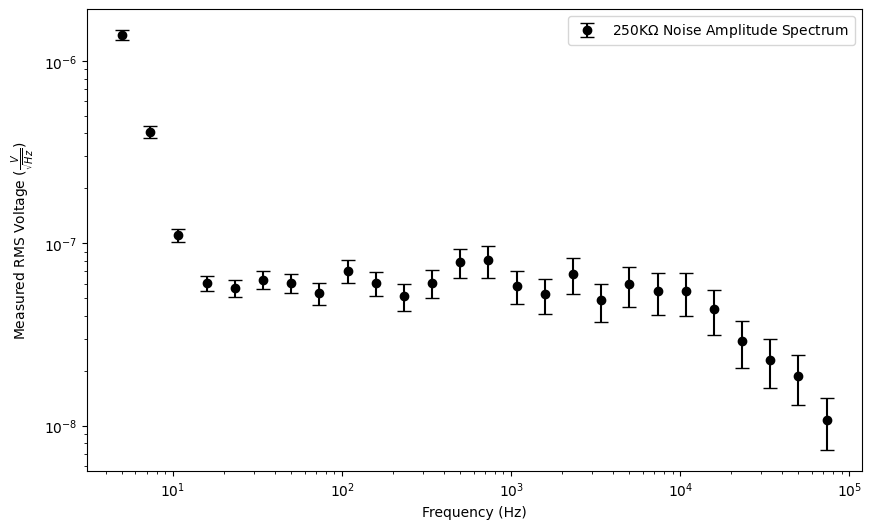

<class 'pandas.core.series.Series'>
Expected thermal noise
(9.0486+/-0.0015)e-08
[7.79668532e-08 4.71142607e-04 3.56213696e+00]
Fit Thermal Noise 7.796685323641696e-08 +/- 3.726642543126927e-09
Reduced Chi2 1.5936497190021068


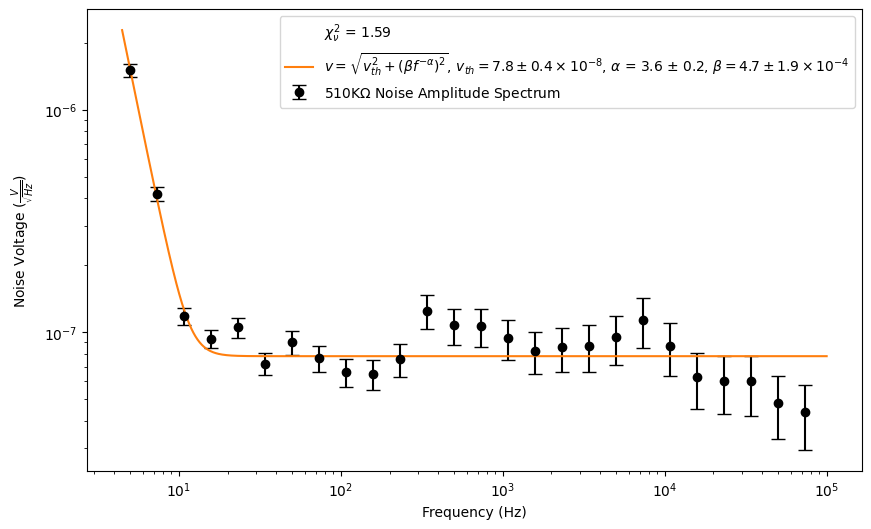

<Figure size 640x480 with 0 Axes>

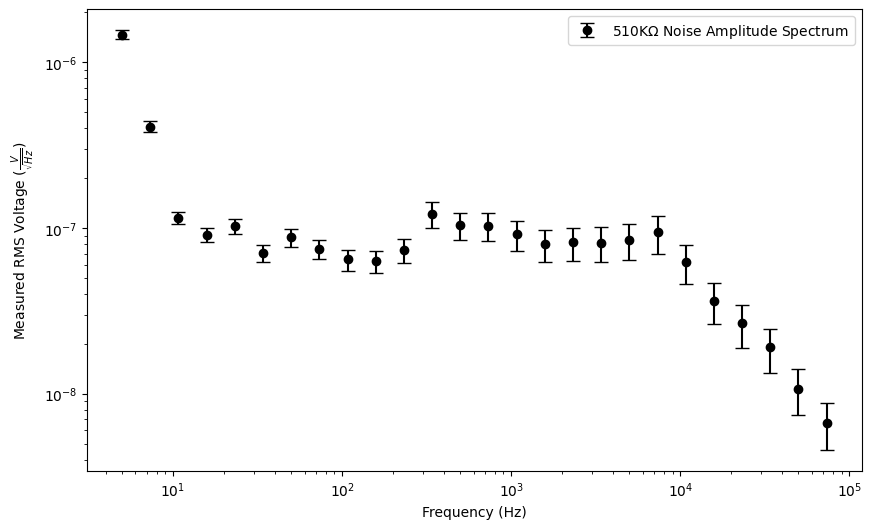

<class 'pandas.core.series.Series'>
Expected thermal noise
(1.26722+/-0.00022)e-07
[1.11589630e-07 2.37896732e-04 3.17028356e+00]
Fit Thermal Noise 1.1158963002390344e-07 +/- 4.681735180799322e-09
Reduced Chi2 1.2431763344764042


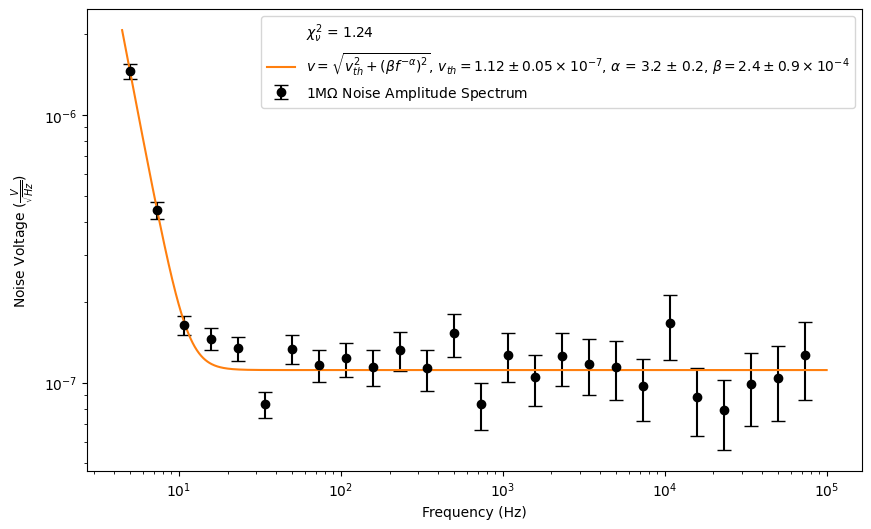

<Figure size 640x480 with 0 Axes>

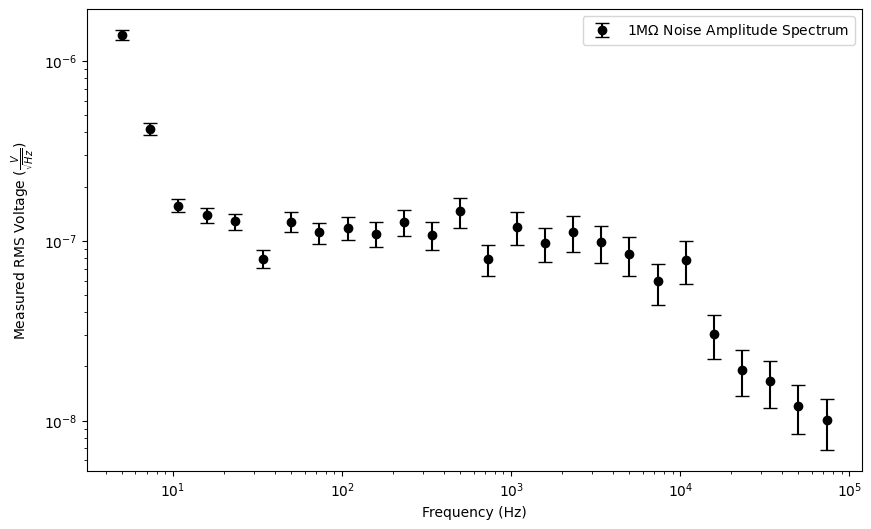

<class 'pandas.core.series.Series'>
Expected thermal noise
(6.47+/-0.04)e-08
[8.70258662e-08 2.13102609e-04 3.19807030e+00]
Fit Thermal Noise 8.702586617938642e-08 +/- 4.887829683485902e-09
Reduced Chi2 2.127378040036798


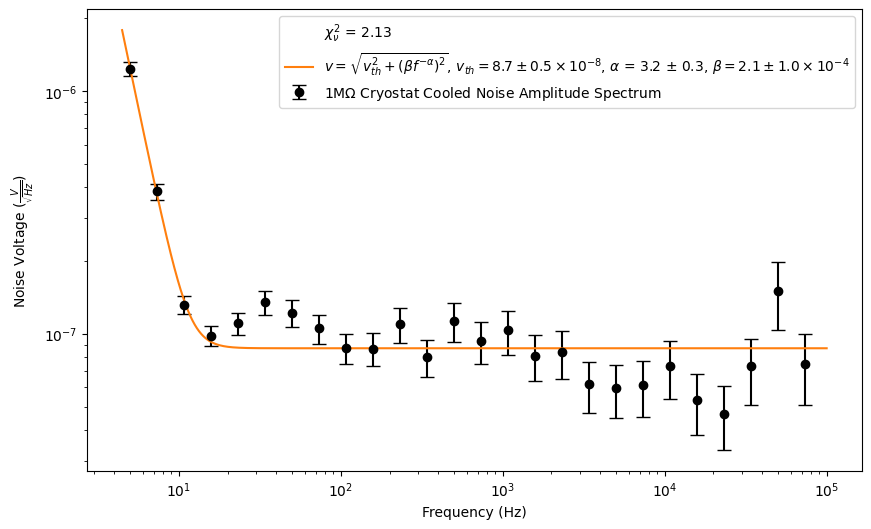

<Figure size 640x480 with 0 Axes>

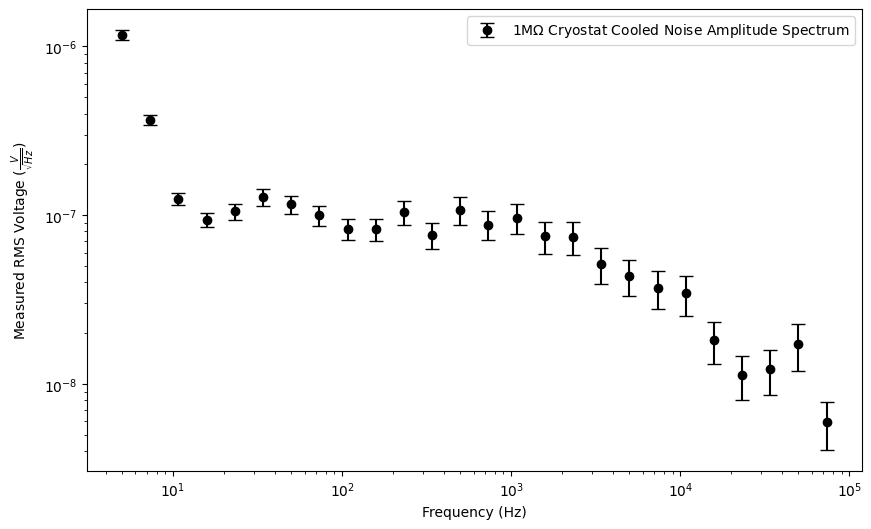

<class 'pandas.core.series.Series'>
Expected thermal noise
(1.26591+/-0.00022)e-07
[1.27023694e-07 4.94511856e-04 3.38741077e+00]
Fit Thermal Noise 1.2702369379057048e-07 +/- 4.739875106345511e-09
Reduced Chi2 0.96995820409895


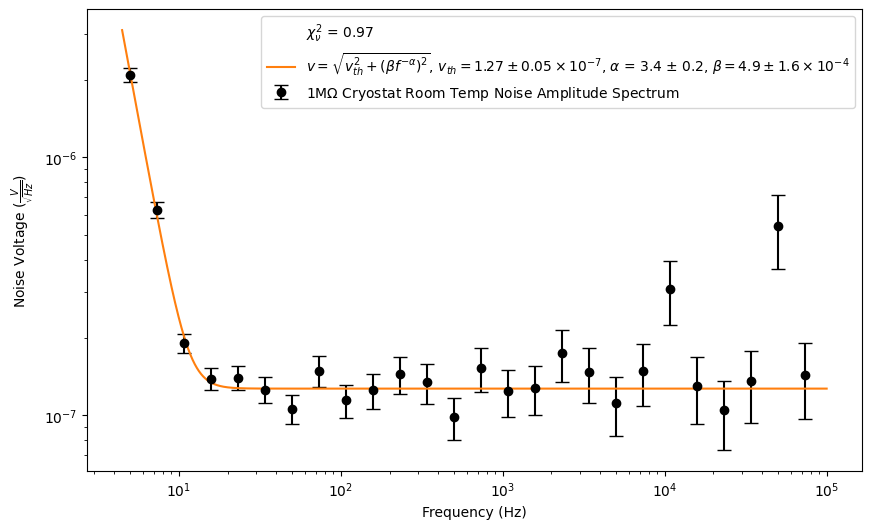

<Figure size 640x480 with 0 Axes>

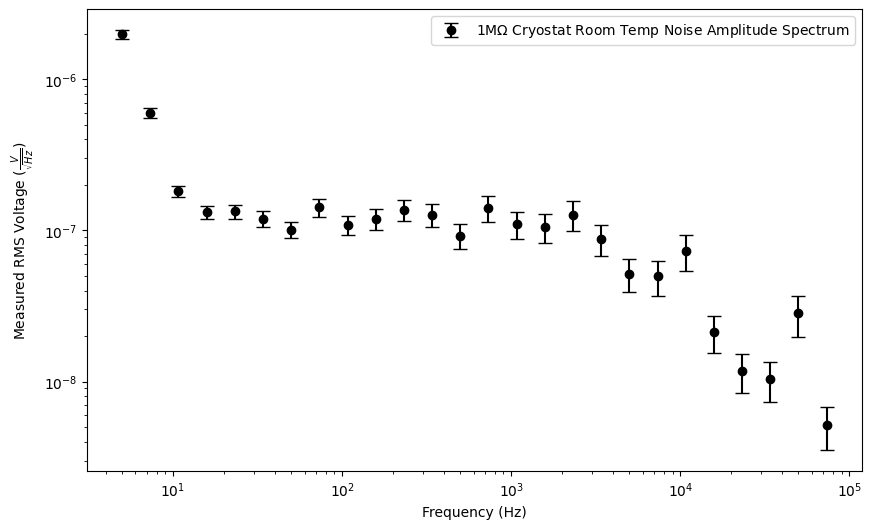

In [5]:
dataFiles = glob.glob("data/*")
print(dataFiles)
voltages = [unc.ufloat(408.5, 0.1)*1e-6, unc.ufloat(199.59, 0.01)*1e-6, unc.ufloat(101.78, 0.01)*1e-6,  unc.ufloat(101.55, 0.01)*1e-6,  unc.ufloat(101.75, 0.01)*1e-6]
resistances = []
for v in voltages:
    resistances.append((100-150*v)/(v))
print(resistances)
temps = [unc.ufloat(22.7+273.3, 0.1), unc.ufloat(22.7+273.3, 0.1), unc.ufloat(22.7+273.3, 0.1), unc.ufloat(77, 1),unc.ufloat(22.0+273.3, 0.1)]
# resistances = [unc.ufloat(250000, 1250), unc.ufloat(510000, 2550), unc.ufloat(1000000, 5000)]
datalabels = [r"250K$\Omega$", r"510K$\Omega$", r"1M$\Omega$", r"1M$\Omega$ Cryostat Cooled", r"1M$\Omega$ Cryostat Room Temp"]

for file, res, tmps, label, i in zip(dataFiles, resistances, temps, datalabels, list(range(len(dataFiles)))):
    freqs, vs = readData(file)
    if i > 3:
        transferFunc = transferCryo(freqs, res)
    else:
        transferFunc = transfer(freqs, res)
    vcUnc = []
    for v, f in zip(vs, freqs):
        vcUnc.append(unc.ufloat(v, v*voltageUncertainty(f)))
    print(type(transferFunc))
    vs = vcUnc/transferFunc
    vsNoUnc = []
    vsUncs = []
    for v in vs:
        vsNoUnc.append(v.n)
        vsUncs.append(v.s)
    temp = unc.ufloat(273.3+22.7, 0.1)
    expectedVal = thermalNoTransfer(res.n, tmps.n)
    expectedVal = np.ones_like(freqs)*expectedVal
    plt.figure(figsize=(10, 6))
    plt.errorbar(freqs, vsNoUnc, vsUncs, label=label + " Noise Amplitude Spectrum", fmt="ko", capsize=5)
    # plt.plot(freqs, expectedVal, label="Expected Thermal Noise")
    print("Expected thermal noise")
    print(thermalNoTransfer(res, tmps))
    popt, pcov = curve_fit(curveFit, freqs, vsNoUnc, sigma=vsUncs, p0=[expectedVal[0], 1e-6, 4], bounds=([0, 0, 0], [1, 1, 5]))
    chi2 = np.sum(np.pow(np.array(vsNoUnc)-curveFit(freqs, *popt), 2)/np.array(vsUncs)**2)/(len(vsNoUnc)-2)
    
    print(popt)
    print("Fit Thermal Noise", popt[0], "+/-", np.sqrt(pcov[0][0]))
    print("Reduced Chi2", chi2)
    betaExponent = np.floor(np.log10(popt[1]))
    beta = popt[1]/10**betaExponent
    betaErr = np.sqrt(pcov[1][1])/10**betaExponent
    vthExponent = np.floor(np.log10(popt[0]))
    vth = popt[0]/10**vthExponent
    vthErr = np.sqrt(pcov[0][0])/10**vthExponent
    alpha = popt[2]
    alphaErr = np.sqrt(pcov[2][2])
    if i ==2 or i == 4:
        fitName = r"$v = \sqrt{v_{th}^2 + (\beta f^{-\alpha})^2}$" + rf", $v_{{th}} = {vth:.2f} \pm {vthErr:.2f} \times 10^{{{vthExponent:.0f}}}$, $\alpha$ = {alpha:.1f} $\pm$ {alphaErr:.1f}, $\beta = {beta:.1f} \pm {betaErr:.1f} \times 10^{{{betaExponent:.0f}}}$"
    else:
        fitName = r"$v = \sqrt{v_{th}^2 + (\beta f^{-\alpha})^2}$" + rf", $v_{{th}} = {vth:.1f} \pm {vthErr:.1f} \times 10^{{{vthExponent:.0f}}}$, $\alpha$ = {alpha:.1f} $\pm$ {alphaErr:.1f}, $\beta = {beta:.1f} \pm {betaErr:.1f} \times 10^{{{betaExponent:.0f}}}$"
    plt.plot([], [], ' ', label=rf"$\chi^2_\nu$ = {chi2:.2f}")
    fs = np.logspace(0.65, 5, num=1000)
    plt.plot(fs, curveFit(fs, *popt), label=fitName)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(r"Noise Voltage $(\frac{V}{\sqrt{Hz}})$")
    plt.legend()
    plt.xscale("log")
    plt.yscale("log")
    plt.savefig(f"plots/{i}.svg", bbox_inches="tight")
    plt.show()
    plt.clf()
    vs = []
    verr = []
    for v in vcUnc:
        vs.append(v.n)
        verr.append(v.s)
    plt.figure(figsize=(10, 6))
    plt.errorbar(freqs, vs, verr, label=label + " Noise Amplitude Spectrum", fmt="ko", capsize=5)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(r"Measured RMS Voltage ($\frac{V}{\sqrt{Hz}}$)")
    plt.legend()
    plt.savefig(f"plots/{i}NoUnc.svg", bbox_inches="tight")
    plt.show()